In [1]:
import time
import copy

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data.dataset import random_split
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

import numpy as np

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
num_epochs = 5
num_classes = 10
batch_size = 128
learning_rate = 0.001

In [4]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, transform=transform)

# Before
print('Train data set:', len(train_dataset))
print('Test data set:', len(test_dataset))

# Random split
train_set_size = int(len(train_dataset) * 0.8)
indices = list(range(train_set_size))
split = int(np.floor(.2 * train_set_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler =  SequentialSampler(val_indices)
   

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=train_sampler,
                                           batch_size=batch_size,
                                           )

valid_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=valid_sampler,
                                           batch_size=batch_size,
                                           )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False)

Train data set: 60000
Test data set: 10000


In [5]:
class NeuralNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, act_func=nn.ReLU()):
        super(NeuralNet, self).__init__()
        layers = []
        layers.append(nn.Linear(in_channels, hidden_channels[0])) # This the first layer [in_channels, hidden_channels[0]]. For example in this exercise: in 784, out 300
        layers.append(act_func) # activation function
        # Hidden layers
        for i in range(1, len(hidden_channels)): 
            layers.append(nn.Linear(hidden_channels[i-1], hidden_channels[i]))
            layers.append(act_func) # activation function
        layers.append(nn.Linear(hidden_channels[-1], out_channels)) # This is the last layers [hidden_channels[-1], out_channels]. For example in this exercise: in 100, out 10
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.net(x)
        return out

In [6]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.reshape(-1, 1*28*28).to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            #nsamples = dataloaders[phase].dataset.data.shape[0]
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.5f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)
Total number of parameters = 316810
Epoch 0/19
----------
train Loss: 2.1429 Acc: 0.40794
val Loss: 1.6779 Acc: 0.63698

Epoch 1/19
----------
train Loss: 0.9436 Acc: 0.77333
val Loss: 0.5527 Acc: 0.85271

Epoch 2/19
----------
train Loss: 0.4710 Acc: 0.86846
val Loss: 0.3976 Acc: 0.89010

Epoch 3/19
----------
train Loss: 0.3799 Acc: 0.89130
val Loss: 0.3478 Acc: 0.90271

Epoch 4/19
----------
train Loss: 0.3380 Acc: 0.90307
val Loss: 0.3166 Acc: 0.91396

Epoch 5/19
----------
train Loss: 0.3079 Acc: 0.91055
val Loss: 0.2982 Acc: 0.91635

Epoch 6/19
----------
train Loss: 0.2842 Acc: 0.91664
val Loss: 0.2737 Acc: 0.92385

Epoch 7/19
----------
train Loss: 0.

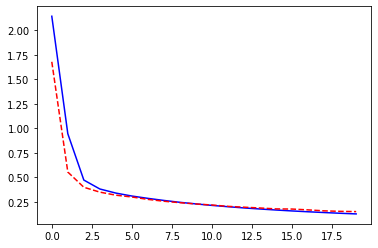

In [7]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = NeuralNet(in_channels=1*28*28, hidden_channels=[300, 200, 100], out_channels=10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [9]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 1*28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.95830 


NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)
Total number of parameters = 316810
Epoch 0/19
----------
train Loss: 0.7533 Acc: 0.78885
val Loss: 0.2454 Acc: 0.93000

Epoch 1/19
----------
train Loss: 0.2014 Acc: 0.93971
val Loss: 0.1833 Acc: 0.94438

Epoch 2/19
----------
train Loss: 0.1330 Acc: 0.96130
val Loss: 0.1272 Acc: 0.96344

Epoch 3/19
----------
train Loss: 0.0954 Acc: 0.97135
val Loss: 0.1177 Acc: 0.96646

Epoch 4/19
----------
train Loss: 0.0715 Acc: 0.97870
val Loss: 0.1085 Acc: 0.96729

Epoch 5/19
----------
train Loss: 0.0544 Acc: 0.98367
val Loss: 0.0943 Acc: 0.97354

Epoch 6/19
----------
train Loss: 0.0407 Acc: 0.98815
val Loss: 0.1059 Acc: 0.96958

Epoch 7/19
----------
train Loss: 0.

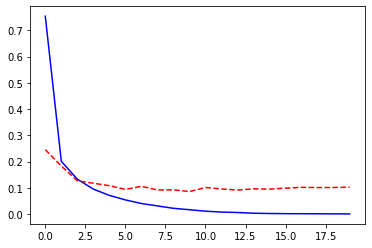

In [10]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = NeuralNet(in_channels=1*28*28, hidden_channels=[300, 200, 100], out_channels=10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [11]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 1*28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.97840 


NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)
Total number of parameters = 316810
Epoch 0/19
----------
train Loss: 0.7362 Acc: 0.78599
val Loss: 0.2517 Acc: 0.92667

Epoch 1/19
----------
train Loss: 0.2054 Acc: 0.93956
val Loss: 0.1690 Acc: 0.94927

Epoch 2/19
----------
train Loss: 0.1350 Acc: 0.95987
val Loss: 0.1314 Acc: 0.95990

Epoch 3/19
----------
train Loss: 0.0943 Acc: 0.97151
val Loss: 0.1117 Acc: 0.96813

Epoch 4/19
----------
train Loss: 0.0704 Acc: 0.97906
val Loss: 0.1112 Acc: 0.96625

Epoch 5/19
----------
train Loss: 0.0523 Acc: 0.98414
val Loss: 0.0904 Acc: 0.97292

Epoch 6/19
----------
train Loss: 0.0388 Acc: 0.98872
val Loss: 0.0850 Acc: 0.97531

Epoch 7/19
----------
train Loss: 0.

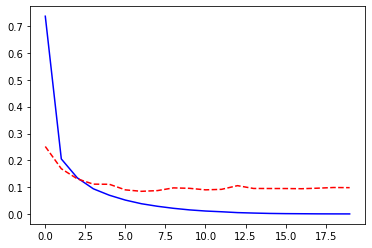

In [12]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = NeuralNet(in_channels=1*28*28, hidden_channels=[300, 200, 100], out_channels=10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9, nesterov=True)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [13]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 1*28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.97720 


NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)
Total number of parameters = 316810
Epoch 0/19
----------
train Loss: 0.5646 Acc: 0.85060
val Loss: 0.3415 Acc: 0.90417

Epoch 1/19
----------
train Loss: 0.3211 Acc: 0.90667
val Loss: 0.2928 Acc: 0.91542

Epoch 2/19
----------
train Loss: 0.2843 Acc: 0.91628
val Loss: 0.2693 Acc: 0.92229

Epoch 3/19
----------
train Loss: 0.2618 Acc: 0.92297
val Loss: 0.2533 Acc: 0.92771

Epoch 4/19
----------
train Loss: 0.2463 Acc: 0.92680
val Loss: 0.2423 Acc: 0.93073

Epoch 5/19
----------
train Loss: 0.2336 Acc: 0.93099
val Loss: 0.2316 Acc: 0.93333

Epoch 6/19
----------
train Loss: 0.2236 Acc: 0.93344
val Loss: 0.2241 Acc: 0.93521

Epoch 7/19
----------
train Loss: 0.

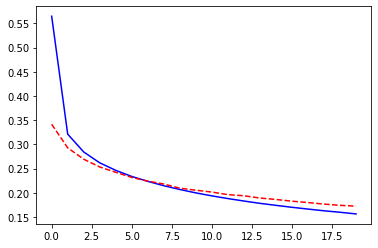

In [14]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = NeuralNet(in_channels=1*28*28, hidden_channels=[300, 200, 100], out_channels=10).to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [15]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 1*28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.95120 


NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)
Total number of parameters = 316810
Epoch 0/19
----------
train Loss: 2.2993 Acc: 0.13372
val Loss: 2.2919 Acc: 0.14438

Epoch 1/19
----------
train Loss: 2.2848 Acc: 0.18500
val Loss: 2.2764 Acc: 0.20063

Epoch 2/19
----------
train Loss: 2.2684 Acc: 0.23935
val Loss: 2.2584 Acc: 0.25927

Epoch 3/19
----------
train Loss: 2.2488 Acc: 0.28185
val Loss: 2.2365 Acc: 0.30188

Epoch 4/19
----------
train Loss: 2.2250 Acc: 0.31427
val Loss: 2.2095 Acc: 0.33385

Epoch 5/19
----------
train Loss: 2.1954 Acc: 0.33789
val Loss: 2.1762 Acc: 0.35260

Epoch 6/19
----------
train Loss: 2.1587 Acc: 0.35823
val Loss: 2.1348 Acc: 0.36552

Epoch 7/19
----------
train Loss: 2.

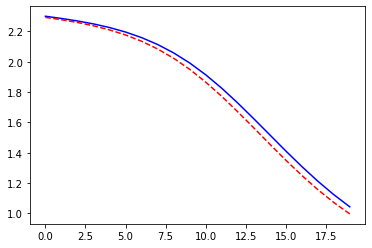

In [16]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = NeuralNet(in_channels=1*28*28, hidden_channels=[300, 200, 100], out_channels=10).to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [17]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 1*28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.79380 


NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)
Total number of parameters = 316810
Epoch 0/19
----------
train Loss: 0.3307 Acc: 0.89383
val Loss: 0.1397 Acc: 0.95677

Epoch 1/19
----------
train Loss: 0.1153 Acc: 0.96432
val Loss: 0.1061 Acc: 0.96792

Epoch 2/19
----------
train Loss: 0.0801 Acc: 0.97471
val Loss: 0.0959 Acc: 0.97063

Epoch 3/19
----------
train Loss: 0.0573 Acc: 0.98138
val Loss: 0.1137 Acc: 0.96854

Epoch 4/19
----------
train Loss: 0.0435 Acc: 0.98630
val Loss: 0.1064 Acc: 0.97177

Epoch 5/19
----------
train Loss: 0.0366 Acc: 0.98823
val Loss: 0.0972 Acc: 0.97333

Epoch 6/19
----------
train Loss: 0.0280 Acc: 0.99078
val Loss: 0.1073 Acc: 0.97313

Epoch 7/19
----------
train Loss: 0.

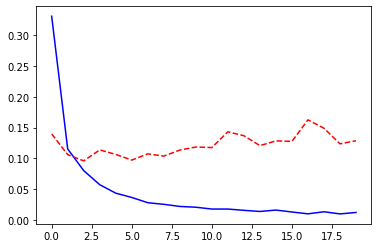

In [18]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = NeuralNet(in_channels=1*28*28, hidden_channels=[300, 200, 100], out_channels=10).to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [19]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 1*28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.97870 


NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)
Total number of parameters = 316810
Epoch 0/19
----------
train Loss: 0.3525 Acc: 0.89320
val Loss: 0.1618 Acc: 0.95208

Epoch 1/19
----------
train Loss: 0.1298 Acc: 0.95917
val Loss: 0.1154 Acc: 0.96385

Epoch 2/19
----------
train Loss: 0.0874 Acc: 0.97292
val Loss: 0.1041 Acc: 0.96906

Epoch 3/19
----------
train Loss: 0.0594 Acc: 0.98112
val Loss: 0.0974 Acc: 0.97188

Epoch 4/19
----------
train Loss: 0.0464 Acc: 0.98482
val Loss: 0.0907 Acc: 0.97458

Epoch 5/19
----------
train Loss: 0.0387 Acc: 0.98737
val Loss: 0.0930 Acc: 0.97333

Epoch 6/19
----------
train Loss: 0.0292 Acc: 0.98979
val Loss: 0.1028 Acc: 0.97313

Epoch 7/19
----------
train Loss: 0.

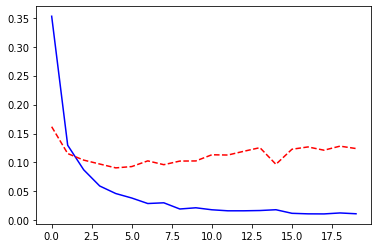

In [20]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = NeuralNet(in_channels=1*28*28, hidden_channels=[300, 200, 100], out_channels=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [21]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 1*28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.98090 
